In [ ]:
From the 3 rav4 drive on June 16 2021
VU2, VU1, Jonathan
CAN bus data & high-end GPS data instrumented on VU1 and VU2

- get the time range that all three cars are on the testbed
- transform from GPS to relataive coordinates
0,0 -> 36.005437, -86.610796
0,48 -> 36.005532, -86.610684
1000,0 -> 36.003404, -86.608529
1000,48 -> 36.003496, -86.608414

320, 0 -> 36.004790, -86.610073

In [1]:
import pandas as pd
import importlib
import utils
importlib.reload(utils)
from os import path
import time
import pathlib
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits import mplot3d
from datetime import datetime
import cv2


Bad key "text.kerning_factor" on line 4 in
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [114]:
data_path = pathlib.Path().absolute().joinpath('../I24_motion_GPS/GPS')
file_name = data_path.joinpath('tableview_210617_192904_VU1.csv')
df1 = utils.read_data(file_name,0,False)
file_name = data_path.joinpath('tableview_210617_192126_VU2.csv')
df2 = utils.read_data(file_name,0,False)
file_name = data_path.joinpath('low_end_GPS/Jonathan_2021-06-16-20-00-18_2T3Y1RFV8KC014025_GPS_Messages.csv')
df3 = utils.read_data(file_name,0,False)

In [115]:
# convert string to datetime and to timestamps
df1 = df1.assign(datetime=[datetime.strptime(df1.UTC[i], '%H:%M:%S.%f %m/%d/%Y') for i in range(len(df1))])
df2 = df2.assign(UTC=[df2.UTC[i].replace('??/??/????','06/16/2021') for i in range(len(df2))])
df2 = df2.assign(datetime=[datetime.strptime(df2.UTC[i], '%H:%M:%S.%f %m/%d/%Y') for i in range(len(df2))])
df1['timestamp'] = df1.datetime.apply(lambda x: x.timestamp())
df2['timestamp'] = df2.datetime.apply(lambda x: x.timestamp())
# GPS time is more reliable but system time can successfully synchronize
df3['timestamp'] = df3.Systime

In [116]:
# select the testbed region based on high-end GPS only
df1s = df1[df1['Lat']<36.014]
df2s = df2[df2['Lat']<36.014]

In [117]:
# select the time range of df3
# find the overlapped time range
laterStart = max(df1s.timestamp.iloc[0],df2s.timestamp.iloc[0],df3.timestamp.iloc[0])
earlyFinish = min(df1s.timestamp.iloc[-1],df2s.timestamp.iloc[-1],df3.timestamp.iloc[-1])
print(earlyFinish-laterStart)
df1s = df1[(df1['timestamp']>=laterStart) & (df1['timestamp']<=earlyFinish)]
df2s = df2[(df2['timestamp']>=laterStart) & (df2['timestamp']<=earlyFinish)]
df3s = df3[(df3['timestamp']>=laterStart) & (df3['timestamp']<=earlyFinish)]
df1s=df1s.reset_index()
df2s=df2s.reset_index()
df3s=df3s.reset_index()

# drop unrelavent columns
df1s = df1s.loc[:, df1s.columns.intersection(['datetime','timestamp','Lat','Lon'])]
df2s = df2s.loc[:, df2s.columns.intersection(['datetime','timestamp','Lat','Lon'])]
df3s = df3s.loc[:, df3s.columns.intersection(['datetime','timestamp','Lat','Long'])]

738.1400001049042


In [118]:
# resample according to 10hz frequency
df1re = df1s.resample('0.1S', on='datetime').mean().interpolate('linear').reset_index()
df2re = df2s.resample('0.1S', on='datetime').mean().interpolate('linear').reset_index()
# resample df3s according to dfres' timestamps
df3s['datetime'] = pd.to_datetime(df3s['timestamp'], unit='s')
df3re=df3s.resample('0.1S', on='datetime').mean().interpolate('linear').reset_index()

nlen = min(len(df1re),len(df2re),len(df3re))
df1re = df1re.iloc[:nlen,:]
df2re = df2re.iloc[:nlen,:]
df3re = df3re.iloc[:nlen,:]
# df2re.drop(df2re.tail(1).index,inplace=True) # drop last n rows

# modify timestamp
df1re['timestamp'] = df1re.datetime.apply(lambda x: x.timestamp())
df2re['timestamp'] = df2re.datetime.apply(lambda x: x.timestamp())
df3re['timestamp'] = df3re.datetime.apply(lambda x: x.timestamp())

In [119]:
# rename columns and concate into one df
df1re = df1re.rename(columns={'Lat':'lat1','Lon':'lon1'})
df2re = df2re.rename(columns={'Lat':'lat2','Lon':'lon2'})
df3re = df3re.rename(columns={'Lat':'lat3','Long':'lon3'})


In [125]:
df2re = df2re.drop(columns=['datetime'])
df3re = df3re.drop(columns=['datetime'])
# dfre = pd.merge(df1re, df2re, df3re, on='timestamp')
dfre = df1re.merge(df2re,on='timestamp').merge(df3re,on='timestamp')

Text(0.5,1,'car 3')

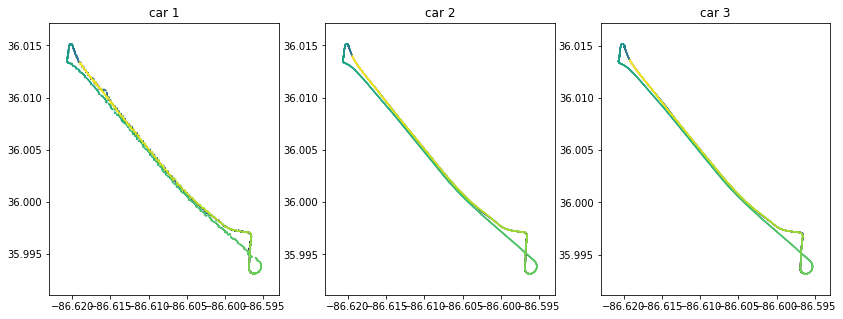

In [130]:
# plt.scatter(df1re.Lon, df1re.Lat,s=0.2,c=df1re.timestamp)
# plt.colorbar()

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(14,5))

ax1.scatter(df1re.lon1, df1re.lat1,s=0.2,c=df1re.timestamp)
ax1.set_title('car 1')
# fig.colorbar()
ax2.scatter(df2re.lon2, df2re.lat2,s=0.2,c=df2re.timestamp)  
ax2.set_title('car 2')
# ax2.colorbar()
ax3.scatter(df3re.lon3, df3re.lat3,s=0.2,c=df2re.timestamp)  
ax3.set_title('car 3')

In [131]:
dfre.to_csv('GPS_vu123_10hz.csv')

In [132]:
# start to add CAN bus information, such as speed and acceleration
# TODO: ask Matt to decode Jonathan's data

data_path = pathlib.Path().absolute().joinpath('../I24_motion_GPS/CAN')
file_name = data_path.joinpath('vu1_2021-06-16-20-15-47_2T3MWRFVXLW056972_masterArray_withRPM.csv')
can1 = utils.read_data(file_name,0,False)
file_name = data_path.joinpath('vu2_2021-06-16-21-07-19_JTMB6RFV5MD010181_masterArray_withRPM.csv')
can2 = utils.read_data(file_name,0,False)

In [135]:
can1['timestamp'] = can1.Time
can2['timestamp'] = can2.Time
can1 = can1[(can1['timestamp']>=laterStart) & (can1['timestamp']<=earlyFinish)]
can2 = can2[(can2['timestamp']>=laterStart) & (can2['timestamp']<=earlyFinish)]
can1 = can1.reset_index()
can2 = can2.reset_index()

In [139]:
# drop unrelavent columns
can1 = can1.loc[:, can1.columns.intersection(['timestamp','Velocity','Acceleration','SpaceGap','RelativeVelocity'])]
can2 = can2.loc[:, can2.columns.intersection(['timestamp','Velocity','Acceleration','SpaceGap','RelativeVelocity'])]

In [142]:
# resample according to 10hz frequency
can1['datetime'] = pd.to_datetime(can1['timestamp'], unit='s')
can2['datetime'] = pd.to_datetime(can2['timestamp'], unit='s')
can1re = can1.resample('0.1S', on='datetime').mean().interpolate('linear').reset_index()
can2re = can2.resample('0.1S', on='datetime').mean().interpolate('linear').reset_index()

nlen = min(len(can1re),len(can2re))
can1re = can1re.iloc[:nlen,:]
can2re = can2re.iloc[:nlen,:]

# modify timestamp
can1re['timestamp'] = can1re.datetime.apply(lambda x: x.timestamp())
can2re['timestamp'] = can2re.datetime.apply(lambda x: x.timestamp())

In [149]:
can1re = can1re.drop(columns=['datetime'])
can2re = can2re.drop(columns=['datetime'])
canre = pd.merge(can1re, can2re, on='timestamp',suffixes=('_1', '_2'))
# canre = df1re.merge(df2re,on='timestamp').merge(df3re,on='timestamp')
canre

,Velocity_1,Acceleration_1,SpaceGap_1,RelativeVelocity_1,timestamp,Velocity_2,Acceleration_2,SpaceGap_2,RelativeVelocity_2
0,5.3500,0.00000,6.6800,0.0400,1.623877e+09,3.67000,1.56000,6.98,NaN
1,5.3550,0.00000,6.6825,-0.0300,1.623877e+09,3.92775,1.66000,6.99,NaN
2,5.3600,0.00000,6.6850,-0.1000,1.623877e+09,4.18550,1.76000,7.00,NaN
3,5.3800,0.00000,6.7175,-0.1050,1.623877e+09,4.45075,1.76000,7.24,NaN
4,5.4000,0.00000,6.7500,-0.1100,1.623877e+09,4.71600,1.76000,7.48,NaN
...,...,...,...,...,...,...,...,...,...
7378,73.3525,-0.85000,33.7800,-1.2025,1.623878e+09,67.32225,-0.77475,252.00,NaN
7379,73.2400,-0.92000,33.6600,-1.2100,1.623878e+09,67.21900,-1.01700,252.00,NaN
7380,73.0600,-0.55850,33.4200,-1.2250,1.623878e+09,67.04250,-0.52150,252.00,NaN
7381,72.9750,-0.55475,33.3300,-1.2275,1.623878e+09,66.97625,-0.37525,252.00,NaN


In [164]:
canre = canre[1:].reset_index(drop=True)

In [166]:
canre.to_csv('CAN_vu12_10hz.csv')

In [196]:
import utils_optimization as opt
importlib.reload(opt)
import utils
importlib.reload(utils)
import os.path
from os import path
import pathlib

data_path = pathlib.Path().absolute().joinpath('../June 2021 Data - 1 minute 5 cameras w RAV 4/rectified')
df = pd.DataFrame()
for root,dirs,files in os.walk(str(data_path)):
    for file in files:
        if file.endswith(".csv"):
            file_name = data_path.joinpath(file)
            camera_name = utils.find_camera_name(file)
            print(file)
            df1 = utils.read_data(file_name)
            df = pd.concat([df, df1])

rectifiedp1c2post.csv
rectifiedp1c3post.csv
rectifiedp1c4post.csv
rectifiedp1c5post.csv
rectifiedp1c6post.csv
rectified_p1c2.csv


FileNotFoundError: [Errno 2] File C:\Users\wangy79\Documents\I24_trajectory\I24-trajectory-generation\..\June 2021 Data - 1 minute 5 cameras w RAV 4\rectified\rectified_p1c2.csv does not exist: 'C:\\Users\\wangy79\\Documents\\I24_trajectory\\I24-trajectory-generation\\..\\June 2021 Data - 1 minute 5 cameras w RAV 4\\rectified\\rectified_p1c2.csv'

In [197]:
# df = df[(df['ID']==316120)|(df['ID']==344120)]
df

,Unnamed: 0,Unnamed: 0.1,Timestamp,ID,Object class,Generation method,fbrx,fbry,fblx,fbly,...,direction,camera,Frame #,acceleration,speed,x,y,theta,width,length
0,0,0.0,1.623878e+09,120.0,sedan,Detector,1666.245691,246.090947,1601.936912,266.879510,...,-1.0,p1c2,0.0,0.0,30.995617,155.506083,30.682278,3.141593,2.41408,4.362202
1,1,1.0,1.623878e+09,120.0,sedan,Detector,1648.186316,235.049399,1584.128794,256.356532,...,-1.0,p1c2,1.0,0.0,30.995617,154.576216,30.682278,3.141593,2.41408,4.362202
2,2,2.0,1.623878e+09,120.0,sedan,Detector,1629.860485,224.484721,1566.297958,245.851070,...,-1.0,p1c2,2.0,0.0,30.995617,153.646348,30.682278,3.141593,2.41408,4.362202
3,3,3.0,1.623878e+09,120.0,sedan,Detector,1613.296523,211.978243,1548.459754,232.600494,...,-1.0,p1c2,3.0,0.0,30.995617,152.716480,30.682278,3.141593,2.41408,4.362202
4,4,4.0,1.623878e+09,120.0,sedan,Detector,1596.191365,201.700549,1531.514838,221.905254,...,-1.0,p1c2,4.0,0.0,30.995617,151.476657,30.682278,3.141593,2.41408,4.362202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19666,19666,19666.0,1.623878e+09,9995160.0,van,Interpolation,792.162834,1528.066376,132.247624,1781.158450,...,-1.0,p1c6,1339.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19667,19667,19667.0,1.623878e+09,9995160.0,van,Interpolation,756.255448,1555.476036,87.468976,1814.477398,...,-1.0,p1c6,1340.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19668,19668,19668.0,1.623878e+09,9995160.0,van,Interpolation,719.449880,1578.645666,42.762254,1847.804766,...,-1.0,p1c6,1341.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19669,19669,19669.0,1.623878e+09,9995160.0,van,Interpolation,683.486022,1605.582004,-1.872874,1881.140518,...,-1.0,p1c6,1342.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [224]:
df1 = df[df['ID']==399120]
df2 = df[df['ID']==316120]
df3 = df[df['ID']==344120]

In [206]:
can = canre[(canre.timestamp>=df.Timestamp.iloc[0]) & (canre.timestamp<=df.Timestamp.iloc[-1])]
gps = dfre[(dfre.timestamp>=df.Timestamp.iloc[0]) & (dfre.timestamp<=df.Timestamp.iloc[-1])]

In [268]:
can1 = canre[(canre.timestamp>=df1.Timestamp.iloc[0]) & (canre.timestamp<=df1.Timestamp.iloc[-1])]
can2 = canre[(canre.timestamp>=df2.Timestamp.iloc[0]) & (canre.timestamp<=df2.Timestamp.iloc[-1])]
gps1 = dfre[(dfre.timestamp>=df1.Timestamp.iloc[0]) & (dfre.timestamp<=df1.Timestamp.iloc[-1])]
gps2 = dfre[(dfre.timestamp>=df2.Timestamp.iloc[0]) & (dfre.timestamp<=df2.Timestamp.iloc[-1])]

In [274]:
v1_can = can1['Velocity_1']/1.609
v2_can = can1['Velocity_2']/1.609

In [279]:
len(df1.speed.values[::3])
len(v1_can)
error1 = df1.speed.values[::3]*2.237 - v1_can[:97]

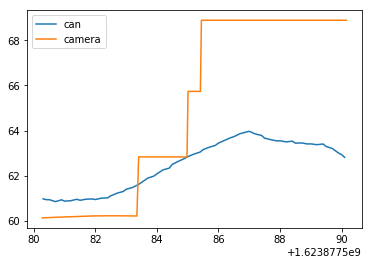

In [287]:
plt.plot(can1.timestamp, v1_can,label='can')
plt.plot(df1.Timestamp, df1.speed*2.237,label='camera')
plt.legend()

No handles with labels found to put in legend.


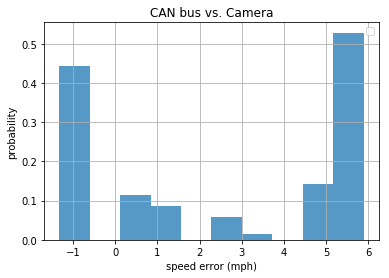

In [282]:
n, bins, patches = plt.hist(error1, density=True, alpha=0.75)
plt.xlabel('speed error (mph)')
plt.ylabel('probability')
plt.title('CAN bus vs. Camera')
# plt.xlim([55,75])
plt.legend()
plt.grid(True)
plt.show()

In [207]:
from datetime import datetime
print('df camera: ', datetime.fromtimestamp(min(df.Timestamp)),datetime.fromtimestamp(max(df.Timestamp)))
print('can: ', datetime.fromtimestamp(min(can.timestamp)),datetime.fromtimestamp(max(can.timestamp)))
print('GPS dfre: ', datetime.fromtimestamp(min(gps.timestamp)),datetime.fromtimestamp(max(gps.timestamp)))

df camera:  2021-06-16 16:05:53.650000 2021-06-16 16:06:53.779999
can:  2021-06-16 16:05:53.700000 2021-06-16 16:06:38.600000
GPS dfre:  2021-06-16 16:05:53.700000 2021-06-16 16:06:38.600000


In [230]:
v1_camera = df1.speed.values * 2.237
v2_camera = df2.speed.values* 2.237
v3_camera = df3.speed.values* 2.237

In [233]:
v1_gps = np.zeros(len(gps1))
v2_gps = np.zeros(len(gps2))
# v3_gps = np.zeros(len(gps3))
for i in range(1,len(gps)):
    dt = gps.timestamp.iloc[i]-gps.timestamp.iloc[i-1]
    d1,_,_ = utils.euclidean_distance(gps['lat1'].iloc[i],gps['lon1'].iloc[i],gps['lat1'].iloc[i-1],gps['lon1'].iloc[i-1])
    v1_gps[i] = d1/dt
    d2,_,_ = utils.euclidean_distance(gps['lat2'].iloc[i],gps['lon2'].iloc[i],gps['lat2'].iloc[i-1],gps['lon2'].iloc[i-1])
    v2_gps[i] = d2/dt
#     d3,_,_ = utils.euclidean_distance(gps['lat3'].iloc[i],gps['lon3'].iloc[i],gps['lat3'].iloc[i-1],gps['lon3'].iloc[i-1])
#     v3_gps[i] = d3/dt
v1_gps[0] = v1_gps[1]
v2_gps[0] = v2_gps[1]
# v3_gps[0] = v3_gps[1]
v1_gps = v1_gps*2.237
v2_gps = v2_gps*2.237
# v3_gps = v3_gps*2.237

<input>:3: DeprecationWarning: invalid escape sequence \m
<input>:3: DeprecationWarning: invalid escape sequence \m
<input>:3: DeprecationWarning: invalid escape sequence \m
<input>:3: DeprecationWarning: invalid escape sequence \m
<input>:3: DeprecationWarning: invalid escape sequence \m
<input>:3: DeprecationWarning: invalid escape sequence \m
<input>:3: DeprecationWarning: invalid escape sequence \m
<input>:3: DeprecationWarning: invalid escape sequence \m
<input>:3: DeprecationWarning: invalid escape sequence \m
<input>:3: DeprecationWarning: invalid escape sequence \m
<input>:3: DeprecationWarning: invalid escape sequence \m
<input>:3: DeprecationWarning: invalid escape sequence \m
<input>:3: DeprecationWarning: invalid escape sequence \m
<input>:3: DeprecationWarning: invalid escape sequence \m
<input>:3: DeprecationWarning: invalid escape sequence \m
<input>:3: DeprecationWarning: invalid escape sequence \m
<input>:3: DeprecationWarning: invalid escape sequence \m
<input>:3: Dep

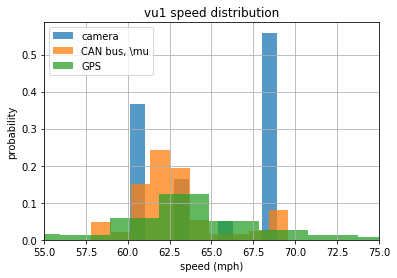

In [256]:
# the histogram of the data
n, bins, patches = plt.hist(v1_camera, density=True, alpha=0.75, label='camera, $\mu$ = {} $\sigma$ '.format(np.mean(v1_camera), c2))
n, bins, patches = plt.hist(v1_can[(v1_can<80)&(v1_can>50)], density=True, alpha=0.75, label='CAN bus, \mu')
n, bins, patches = plt.hist(v1_gps[(v1_gps<80)&(v1_gps>50)], density=True, alpha=0.75, label='GPS')
plt.xlabel('speed (mph)')
plt.ylabel('probability')
plt.title('vu1 speed distribution')
plt.xlim([55,75])
plt.legend()
plt.grid(True)
plt.show()

In [267]:
len(df3)

291

In [255]:
np.std(v1_camera)

3.9372613209060963

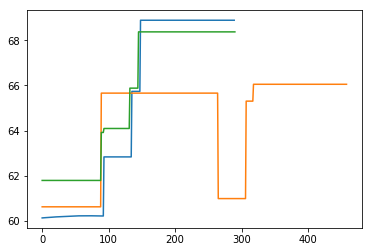

In [227]:
plt.plot(v1_camera*) 
plt.plot(v2_camera*2.237)
plt.plot(v3_camera*2.237)

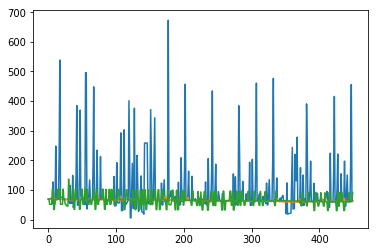

In [223]:
plt.plot(v1_gps*2.237) 
plt.plot(v2_gps*2.237)
plt.plot(v3_gps*2.237)

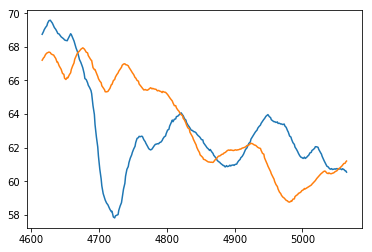

In [222]:
plt.plot(v1_can)
plt.plot(v2_can)

In [ ]:
v1_gps = 

In [210]:
s_gps,_,_ = utils.euclidean_distance(gps.lat2, gps.lon2, gps.lat3, gps.lon3)
s_gps

4616    31.478994
4617    31.427157
4618    32.166329
4619    32.891473
4620    33.619128
          ...    
5061    24.196278
5062    24.221929
5063    24.266183
5064    24.273740
5065    22.919417
Length: 450, dtype: float64

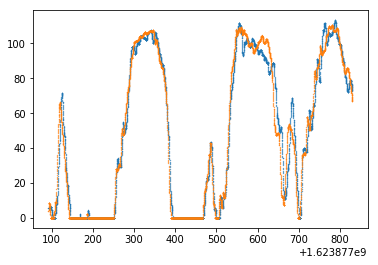

In [153]:
plt.scatter(canre.timestamp,canre.Velocity_1,s=0.1)
plt.scatter(canre.timestamp,canre.Velocity_2,s=0.1)

In [171]:
utils.draw_map_scatter(df2s.Lat.values[::50], df2s.Lon.values[::50])


###############################

 Beginning Key Insertion ...

Key Insertion Completed!!


C:\Users\wangy79\Documents\I24_trajectory\I24-trajectory-generation\utils.py:235: ResourceWarning: unclosed file <_io.TextIOWrapper name='test.html' mode='r' encoding='cp1252'>
  htmltxt = open(fname, 'r').read()
C:\Users\wangy79\Documents\I24_trajectory\I24-trajectory-generation\utils.py:239: ResourceWarning: unclosed file <_io.TextIOWrapper name='test.html' mode='w' encoding='cp1252'>
  open(fname, 'w').write(newtxt)


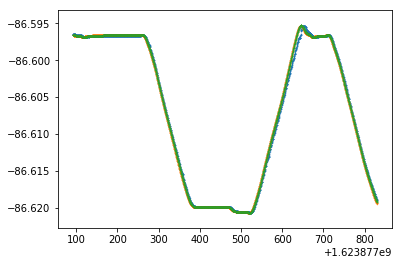

In [128]:
plt.scatter(dfre.timestamp,dfre.lon1,s=0.1)
plt.scatter(dfre.timestamp,dfre.lon2,s=0.1)
plt.scatter(dfre.timestamp,dfre.lon3,s=0.1)

In [165]:
points = np.array(dfre[['lat1','lon1','lat2','lon2']])

In [167]:
d,_,_ = utils.euclidean_distance(points[:,0], points[:,1],points[:,2], points[:,3])


array([20.93868037, 20.92431305, 20.89857657, ..., 37.1714078 ,
       37.16180904, 37.17896861])

In [2]:
# now look at CAN bus data
data_path = pathlib.Path().absolute().joinpath('../I24_motion_GPS')
file_name = data_path.joinpath('CAN/vu1_2021-06-16-20-15-47_2T3MWRFVXLW056972_masterArray_withRPM.csv')
df1 = utils.read_data(file_name,0,False)
file_name = data_path.joinpath('CAN/vu2_2021-06-16-21-07-19_JTMB6RFV5MD010181_masterArray_withRPM.csv')
df2 = utils.read_data(file_name,0,False)

In [13]:
# select the testbed region
df1s = df1[df1['LatitudeGPS']<36.04]
df2s = df2[df2['LatitudeGPS']<36.04]
gps_pts = np.array(df1s[['LatitudeGPS','LongitudeGPS']])
road_pts = utils.gps_to_road(gps_pts)
road_pts

C:\Users\wangy79\Documents\I24_trajectory\I24-trajectory-generation\utils.py:343: RuntimeWarning: invalid value encountered in sqrt
  area = (s*(s-toA)*(s-toB)*(s-AB)) ** 0.5


array([[5.33504709e+03, 3.25428698e+01],
       [5.33243201e+03, 3.19767482e+01],
       [5.32982903e+03, 3.14239326e+01],
       ...,
       [5.29826002e+03, 4.24125137e-01],
       [           nan,            nan],
       [           nan,            nan]])

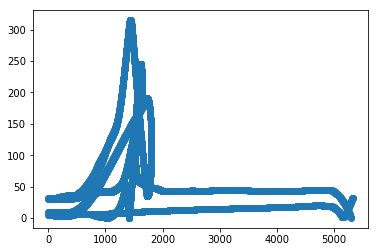

In [14]:
plt.scatter(road_pts[:,0],road_pts[:,1])

In [ ]:
# visualize GPS data from 08/06 vandertest
# LCS to GPS transformation points
0,0 -> 36.005437, -86.610796
0,48 -> 36.005532, -86.610684
1000,0 -> 36.003404, -86.608529
1000,48 -> 36.003496, -86.608414

In [41]:
# 320, 0 -> 36.004790, -86.610073
# 320,48 -> 36.004878, -86.609956
# 320+1691, 0 -> 36.001382, -86.606184
# 320+1691,48 -> 36.001482, -86.606080

import utils
importlib.reload(utils)
d,dx,dy = utils.euclidean_distance(36.004790,-86.610073,36.001382, -86.606184)
d*3.28

1691.6329431240708

In [62]:
gps_ref = np.array([[36.004790, -86.610073],[36.004878, -86.609956],[36.001382, -86.606184],[36.001482, -86.606080]])
lmcs_ref = np.array([[320,0],[320,48],[320+1691,0],[320+1691,48]])
H, mask = cv2.findHomography(gps_ref, lmcs_ref) # gps to feet

In [63]:
# read data and convert to local coordinates
data_path = pathlib.Path().absolute().joinpath('../gps_0806')
file_name = data_path.joinpath('2021-08-06-11-40-19_2T3MWRFVXLW056972_GPS_Messages.csv')
df = utils.read_data(file_name)

In [64]:
df = df[df.Gpstime > 0]

In [65]:
import utils
importlib.reload(utils)
gps_pts = np.array(df[['Lat','Long']])
lmcs_pts = utils.transform_pt_array(gps_pts, H)

Text(0,0.5,'Latitude')

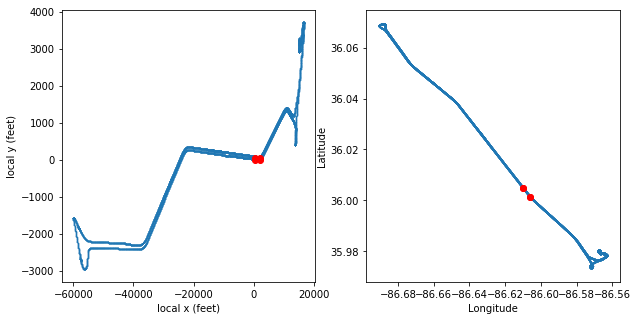

In [66]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
ax1.scatter(lmcs_pts[:,0],lmcs_pts[:,1],s=0.1)
ax1.scatter(lmcs_ref[:,0], lmcs_ref[:,1],c='red')
ax1.set_xlabel('local x (feet)')
ax1.set_ylabel('local y (feet)')
# ax1.set_xlim([-100,2000])
# ax1.set_ylim([-10,150])
ax2.scatter(df.Long, df.Lat,s=0.1)
ax2.scatter(gps_ref[:,1], gps_ref[:,0],c='red')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')

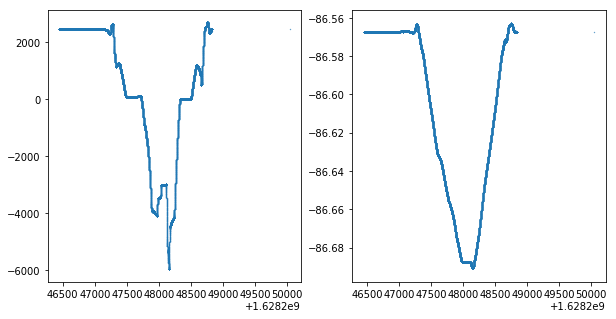

In [23]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
ax1.scatter(df.Gpstime, lmcs_pts[:,1],s=0.1)
ax2.scatter(df.Gpstime, df.Long,s=0.1)

In [ ]:
# get another set of reference points